In [1]:
import numpy as np
from scipy import *
from pylab import *
import os
import pickle

%matplotlib inline

In [2]:
folder_HMF = '/pscratch/sd/j/jialiu/CAMELS/Rockstar/' ### original, unorganized halo catalogue from rockstar
home = '/global/homes/j/jialiu/cosmo_dep_feedback/'

In [3]:
### fixed parameters: 
Omega_b = 0.049
h = 0.6711
ns = 0.9624
w = -1
mnu = 0.0 #eV
Omega_k = 0.0

In [70]:
test_fn = '/global/homes/j/jialiu/cosmo_dep_feedback/CAMELS/Rockstar/Astrid/1P/1P_0/hlists/hlist_1.00000.list'
hmf = np.loadtxt(test_fn, usecols=[1, 10, 11, 12, 17, 18, 19, 26, 47])
# id(1), Mvir(10), Rvir(11), rs(12), x(17) y(18) z(19), Spin(26),c_to_a(47)

folder_plot = home+'plots/'

cmap = matplotlib.cm.get_cmap('Spectral') #('viridis')#

(5030, 9) [ 8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5
 15.  15.5 16. ]


Text(0, 0.5, 'N')

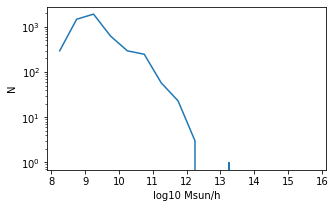

In [23]:
mbins = linspace(8,16, 17)
dmbin = mbins[1]-mbins[0]
mbins_center = mbins[:-1]+0.5*dmbin
print (hmf.shape, mbins)
dmdn,y=histogram(log10(hmf[:,1]), bins=mbins)
f, ax=subplots(1,1, figsize=(5,3))
ax.plot(mbins_center,dmdn)
ax.set_yscale('log')
ax.set_xlabel('log10 Msun/h')
ax.set_ylabel('N')

In [49]:
labels=[r'$\Omega_m$', r'$\sigma_8$', '$log_{10}(A_1)$', '$log_{10}(A_2)$', '$log_{10}(A_3)$', '$log_{10}(A_4)$']

#scale(0) id(1) desc_scale(2) desc_id(3) num_prog(4) pid(5) upid(6) desc_pid(7) phantom(8) sam_Mvir(9) Mvir(10) 
# Rvir(11) rs(12) vrms(13) mmp?(14) scale_of_last_MM(15) vmax(16) x(17) y(18) z(19) vx(20) vy(21) 
# vz(22) Jx(23) Jy(24) Jz(25) Spin(26) Breadth_first_ID(27) Depth_first_ID(28) Tree_root_ID(29) Orig_halo_ID(30) 
# Snap_idx(31) Next_coprogenitor_depthfirst_ID(32) Last_progenitor_depthfirst_ID(33) Last_mainleaf_depthfirst_ID(34) 
# Tidal_Force(35) Tidal_ID(36) Rs_Klypin(37) Mvir_all(38) M200b(39) M200c(40) M500c(41) M2500c(42) Xoff(43) Voff(44) 
# Spin_Bullock(45) b_to_a(46) c_to_a(47) A[x](48) A[y](49) A[z](50) b_to_a(500c)(51) c_to_a(500c)(52) A[x](500c)(53) 
# A[y](500c)(54) A[z](500c)(55) T/|U|(56) M_pe_Behroozi(57) M_pe_Diemer(58) Type(59) SM(60) Gas(61) BH_Mass(62) Macc(63) 
# Mpeak(64) Vacc(65) Vpeak(66) Halfmass_Scale(67) Acc_Rate_Inst(68) Acc_Rate_100Myr(69) Acc_Rate_1*Tdyn(70) Acc_Rate_2*Tdyn(71) 
# Acc_Rate_Mpeak(72) Acc_Log_Vmax_Inst(73) Acc_Log_Vmax_1*Tdyn(74) Mpeak_Scale(75) Acc_Scale(76) First_Acc_Scale(77) 
# First_Acc_Mvir(78) First_Acc_Vmax(79) Vmax\@Mpeak(80) Tidal_Force_Tdyn(81) Log_(Vmax/Vmax_max(Tdyn;Tmpeak))(82) 
# Time_to_future_merger(83) Future_merger_MMP_ID(84)

# test_fn = '/global/homes/j/jialiu/cosmo_dep_feedback/CAMELS/Rockstar/Astrid/1P/1P_0/hlists/hlist_1.00000.list'

### organize the files
def return_hmf (fn, mbins=mbins):
    cat = np.loadtxt(fn, usecols=[10])
    hmf = histogram(log10(cat), bins=mbins)[0]
    return hmf  
    
def organize_HMF (iz, isim, iset='1P'):
    '''For each halo cat, return both the Mass-binned HMF, as well as abundance matched halos; check for hydro if only CDM particles are used..?'''
    ia=1/(1+iz)

    sim_name = np.loadtxt(home+'params/CosmoAstroSeed_%s.txt'%(isim), usecols=(0), dtype='U') ## the simulation names, e.g. "1P_1_n5"
    sim_params = np.loadtxt(home+'params/CosmoAstroSeed_%s.txt'%(isim), usecols=range(1,7)) ## the actual parameters, corresponding to the sim names above
    #### change all the baryon parameters to log
    sim_params = concatenate([sim_params[:,:2], log10(sim_params[:,2:])],axis=1)
    
    iset = '1P'
    idx = where(np.char.find(sim_name, iset)!=-1)
    sim_name = sim_name[idx]
    sim_params = sim_params[idx]
    
    #### load all the Pk in next line, takes long time
    ## Astrid/1P/1P_0/hlists/hlist_1.00000.list'
    hmf_arr = array([return_hmf(folder_HMF+'%s/%s/%s/hlists/hlist_%.5f.list'%(isim, iLH[:2], iLH, ia)) for iLH in sim_name])
    hmf_DM_arr = array([return_hmf(folder_HMF+'%s_DM/%s/%s/hlists/hlist_%.5f.list'%(isim, iLH[:2], iLH, ia)) for iLH in sim_name])
    
    # for iset in ('LH', '1P', 'CV'): ##('1P', ): ##
    ifn=home+'halos/%s_%s_z=%.2f.npy'%(isim, iset, iz)
    ifn_DM=home+'halos/%s_%s_z=%.2f_DM.npy'%(isim, iset, iz)
    data_arr = concatenate([sim_params, hmf_arr],axis=1) ## include params and hmf
    save(ifn, data_arr)
    data_DM_arr = concatenate([sim_params, hmf_DM_arr],axis=1) ## include params and hmf
    save(ifn_DM, data_DM_arr)
        
    print ('%s, %s set has %i models, data shape %s'%(isim, iset, len(idx[0]), data_arr.shape))

In [50]:
######## all CAMELS sims
sim_arr = ['IllustrisTNG',  'SIMBA']  #, 'Astrid'] ## seems like Astrid files are there, but naming system is different

######### the redshift we're interested in
zarr=[0.00, ]#1.05, 2.00, 3.00] #, 0.05, 0.10, 0.15] #

####### organize the files, take long #########
for isim in sim_arr:
    for iz in zarr:
        print (isim, iz)
        organize_HMF (iz, isim)


IllustrisTNG 0.0
IllustrisTNG, 1P set has 66 models, data shape (66, 22)
SIMBA 0.0
SIMBA, 1P set has 66 models, data shape (66, 22)


/tmp/ipykernel_1358503/1058254486.py:15: RuntimeWarning: divide by zero encountered in true_divide
  r = hmf_arr[:, 6:]/hmf_DM_arr[:, 6:]
/tmp/ipykernel_1358503/1058254486.py:15: RuntimeWarning: invalid value encountered in true_divide
  r = hmf_arr[:, 6:]/hmf_DM_arr[:, 6:]


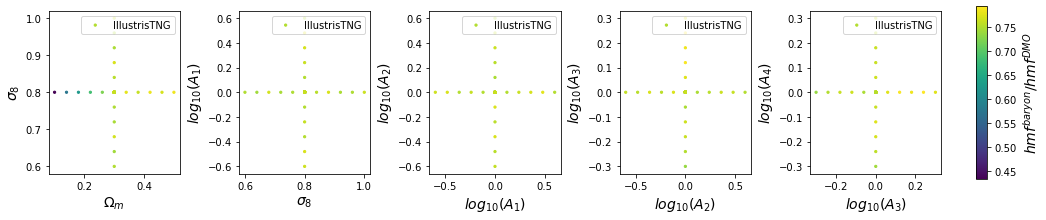

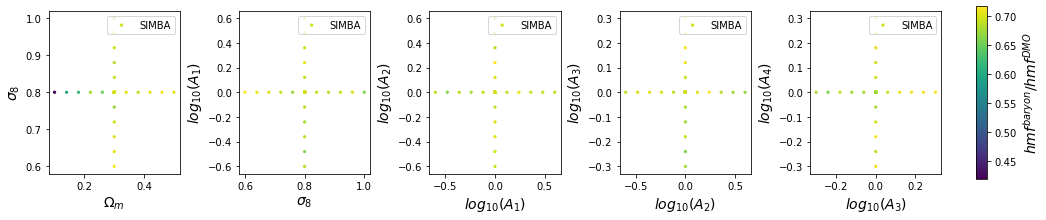

In [66]:
########### validate the tests
iz = 0
iset = '1P'
isim = 'IllustrisTNG'
ix=5 ## m bin to look at ratio

for isim in sim_arr:
    ifn=home+'halos/%s_%s_z=%.2f.npy'%(isim, iset, iz)
    ifn_DM=home+'halos/%s_%s_z=%.2f_DM.npy'%(isim, iset, iz)
    hmf_arr = np.load(ifn)
    hmf_DM_arr = np.load(ifn_DM)
    hmf_arr.shape

    params = hmf_arr[:, :6]
    r = hmf_arr[:, 6:]/hmf_DM_arr[:, 6:]
    rprox = r[:, ix]
    im=mbins[ix]
    # params.shape, r.shape, rprox.shape

    f, ax=subplots(1,5, figsize=(16,3))

    for i in range(5):
        im=ax[i].scatter(params.T[i], params.T[i+1], c=rprox, label=isim, s=5)
        ax[i].set_xlabel(labels[i], fontsize=14)
        ax[i].set_ylabel(labels[i+1],fontsize=14)   
        ax[i].legend()
    cbar_ax = f.add_axes([0.93, 0.1, 0.01, 0.8])
    f.colorbar(im, cax=cbar_ax)
    f.subplots_adjust(wspace=0.45)
    cbar_ax.set_ylabel(r'$hmf^{baryon}/hmf^{DMO}$',fontsize=14)
    show()

In [64]:
r[:,5]
# mbins[5]

10.5

/tmp/ipykernel_1358503/1978764312.py:11: RuntimeWarning: divide by zero encountered in true_divide
  r = hmf_arr[:, 6:]/hmf_DM_arr[:, 6:]
/tmp/ipykernel_1358503/1978764312.py:11: RuntimeWarning: invalid value encountered in true_divide
  r = hmf_arr[:, 6:]/hmf_DM_arr[:, 6:]


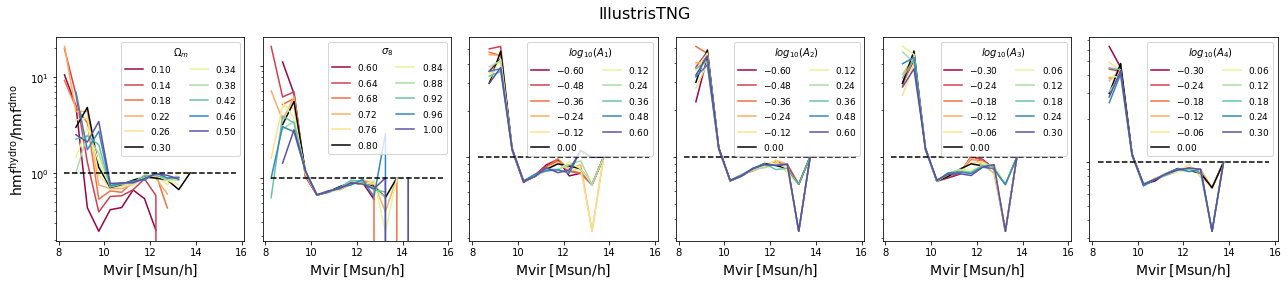

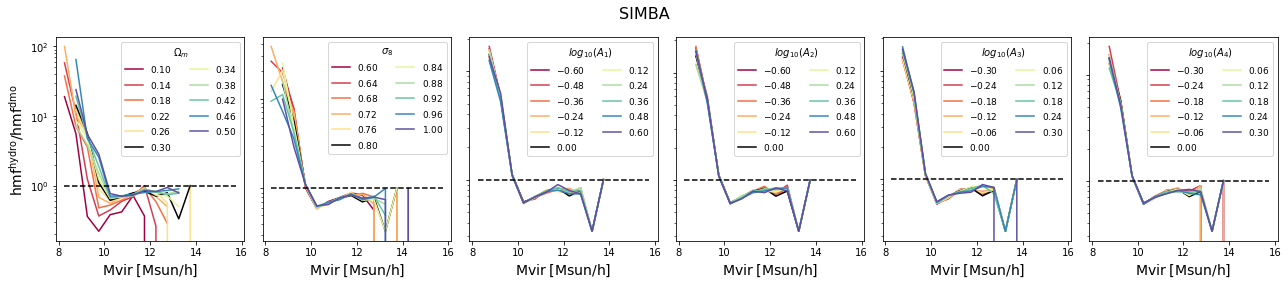

In [77]:
fidu_params = [ 0.3, 0.8 ,0. ,  0. ,0. ,0.]

for isim in ['IllustrisTNG', 'SIMBA']:
    ifn=home+'halos/%s_%s_z=%.2f.npy'%(isim, iset, iz)
    ifn_DM=home+'halos/%s_%s_z=%.2f_DM.npy'%(isim, iset, iz)
    hmf_arr = np.load(ifn)
    hmf_DM_arr = np.load(ifn_DM)
    hmf_arr.shape

    params = hmf_arr[:, :6]
    r = hmf_arr[:, 6:]/hmf_DM_arr[:, 6:]
    params.shape, hmf_arr.shape

    f, axes=subplots(1, 6, figsize=(18,4))
    for i in range(6): ## number of parameters
        ax=axes.reshape(-1)[i]
        idx = where(params[:,i]!=fidu_params[i])[0] # select the varying one on specific parameter
        idx = concatenate([idx[:5], [0,], idx[5:]]) ## inserting the fiducial model in the middle
        j=0
        colors = cmap(linspace(0,1,len(idx)))
        for iidx in idx:
            icolor=colors[j]
            if j==5: ## fiducial model
                icolor='k'
            iparam=params[iidx,i]
            ax.plot(mbins_center, r[iidx], c=icolor,label='$%.2f$'%(iparam))
            j+=1
            
        ax.legend(title='%s'%(labels[i]),ncol=2,fontsize=9,loc='upper right')
        ax.set_yscale('log')
        # ax.set_ylim(0.5, 1.1)
        # ax.set_xlim(0.12, 25)
        ax.set_xlabel(r'$\rm Mvir \;[Msun/h]$',fontsize=14)
        ax.plot(mbins_center, ones(len(mbins_center)), 'k--')
        
        if i == 0:
            # ax.set_title(isim,fontsize=14)
            ax.set_ylabel(r'$\rm hmf^{hydro}/hmf^{dmo}$',fontsize=14)
        else:
            ax.yaxis.set_ticklabels([])
    f.suptitle(isim, fontsize=16)        
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.tight_layout()
    # f.savefig(folder_plot+'%s_Pk_m_ratio.pdf'%(isim))
    show()